참고 : https://github.com/hanyoseob/pytorch-noise2void

## 1. dataset.py

**Masking-scheme에 주목 (generate_mask)**

![image](https://user-images.githubusercontent.com/44194558/155277335-f6290030-a904-4724-b44d-f63897ef160e.png)

<br/>

![image](https://user-images.githubusercontent.com/44194558/155277503-7b165a1a-572e-41bf-8c24-c0cf698e5bc5.png)

<br/>

`data = {'label': label, 'input': input, 'mask': mask}`

 - label : noise 이미지
 - input : label에 mask가 적용된 이미지 
 - mask : masking 행렬 (blind spot)

In [25]:
import numpy as np
import torch
import skimage
from skimage import transform
import matplotlib.pyplot as plt
import os
import copy

In [26]:
class Dataset(torch.utils.data.Dataset):
    """
    dataset of image files of the form 
       stuff<number>_trans.pt
       stuff<number>_density.pt
    """

    def __init__(self, data_dir, data_type='float32', transform=None, sgm=25, ratio=0.9, size_data=(256, 256, 3), size_window=(5, 5)):
        self.data_dir = data_dir
        self.transform = transform
        self.data_type = data_type
        self.sgm = sgm

        self.ratio = ratio
        self.size_data = size_data
        self.size_window = size_window

        lst_data = os.listdir(data_dir)

        # lst_input = [f for f in lst_data if f.startswith('input')]
        # lst_label = [f for f in lst_data if f.startswith('label')]
        #
        # lst_input.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        # lst_label.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        #
        # self.lst_input = lst_input
        # self.lst_label = lst_label

        lst_data.sort(key=lambda f: (''.join(filter(str.isdigit, f))))
        # lst_data.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

        self.lst_data = lst_data
        self.noise = self.sgm / 255.0 * np.random.randn(len(self.lst_data), self.size_data[0], self.size_data[1], self.size_data[2])

    def __getitem__(self, index):
        # label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        # input = np.load(os.path.join(self.data_dir, self.lst_input[index]))
        #
        # if label.dtype == np.uint8:
        #     label = label / 255.0
        # if input.dtype == np.uint8:
        #     input = input / 255.0
        #
        # if label.ndim == 2:
        #     label = np.expand_dims(label, axis=2)
        # if input.ndim == 2:
        #     input = np.expand_dims(input, axis=2)
        #
        # if self.ny != label.shape[0]:
        #     label = label.transpose((1, 0, 2))
        # if self.ny != input.shape[0]:
        #     input = input.transpose((1, 0, 2))
        #
        # data = {'input': input, 'label': label}

        data = plt.imread(os.path.join(self.data_dir, self.lst_data[index]))

        if data.dtype == np.uint8:
            data = data / 255.0

        if data.ndim == 2:
            data = np.expand_dims(data, axis=2)

        if data.shape[0] > data.shape[1]:
            data = data.transpose((1, 0, 2))

        label = data + self.noise[index]  # zero mean noise 추가
        input, mask = self.generate_mask(copy.deepcopy(label))

        data = {'label': label, 'input': input, 'mask': mask}

        if self.transform:
            data = self.transform(data)

        return data

    def __len__(self):
        return len(self.lst_data)

    def generate_mask(self, input):

        ratio = self.ratio
        size_window = self.size_window
        size_data = self.size_data
        num_sample = int(size_data[0] * size_data[1] * (1 - ratio))  # num_sample만큼 랜덤하게 blind spot용 픽셀을 추출

        mask = np.ones(size_data)  # blind spot들만 0, 나머지 픽셀들은 1이 되도록 해야함
        output = input

        for ich in range(size_data[2]):
            idy_msk = np.random.randint(0, size_data[0], num_sample)
            idx_msk = np.random.randint(0, size_data[1], num_sample)

            idy_neigh = np.random.randint(-size_window[0] // 2 + size_window[0] % 2, size_window[0] // 2 + size_window[0] % 2, num_sample)
            idx_neigh = np.random.randint(-size_window[1] // 2 + size_window[1] % 2, size_window[1] // 2 + size_window[1] % 2, num_sample)

            idy_msk_neigh = idy_msk + idy_neigh
            idx_msk_neigh = idx_msk + idx_neigh

            idy_msk_neigh = idy_msk_neigh + (idy_msk_neigh < 0) * size_data[0] - (idy_msk_neigh >= size_data[0]) * size_data[0]
            idx_msk_neigh = idx_msk_neigh + (idx_msk_neigh < 0) * size_data[1] - (idx_msk_neigh >= size_data[1]) * size_data[1]

            id_msk = (idy_msk, idx_msk, ich)
            id_msk_neigh = (idy_msk_neigh, idx_msk_neigh, ich)

            output[id_msk] = input[id_msk_neigh]  # 학습 시 입력으로 사용됨 (손실은 masking된 blind spot pixel들에 대해서만 계산됨)
            mask[id_msk] = 0.0

        return output, mask

### Blind-spot masking scheme 확인

torch.Size([3, 256, 256])


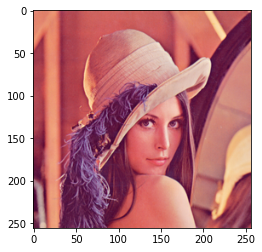

In [89]:
import PIL
import torchvision.transforms as transforms

img = PIL.Image.open('/content/lenna.bmp')
size_data = (256, 256, 3)

noise = 25 / 255.0 * np.random.randn(size_data[2], size_data[1], size_data[0])

tf = transforms.ToTensor()
label = tf(img)
#label += noise  # noise 추가
print(label.shape)

np_label = label.numpy()
plt.imshow(np.transpose(label, (1,2,0)))

In [90]:
size_data = (3, 256, 256)
size_window = (5, 5)
ratio = 0.9  
num_sample = int(size_data[0] * size_data[1] * (1 - ratio))  # 76
input = label

mask = np.ones(size_data)
output = input

for ich in range(size_data[2]):
    idy_msk = np.random.randint(0, size_data[0], num_sample)
    idx_msk = np.random.randint(0, size_data[1], num_sample)

    idy_neigh = np.random.randint(-size_window[0] // 2 + size_window[0] % 2, size_window[0] // 2 + size_window[0] % 2, num_sample)
    idx_neigh = np.random.randint(-size_window[1] // 2 + size_window[1] % 2, size_window[1] // 2 + size_window[1] % 2, num_sample)

    idy_msk_neigh = idy_msk + idy_neigh
    idx_msk_neigh = idx_msk + idx_neigh

    idy_msk_neigh = idy_msk_neigh + (idy_msk_neigh < 0) * size_data[0] - (idy_msk_neigh >= size_data[0]) * size_data[0]
    idx_msk_neigh = idx_msk_neigh + (idx_msk_neigh < 0) * size_data[1] - (idx_msk_neigh >= size_data[1]) * size_data[1]

    id_msk = (idy_msk, idx_msk, ich)
    id_msk_neigh = (idy_msk_neigh, idx_msk_neigh, ich)

    output[id_msk] = input[id_msk_neigh]
    mask[id_msk] = 0.0

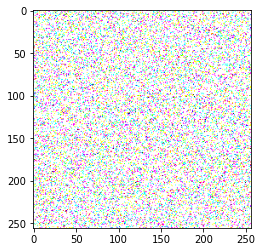

In [91]:
plt.imshow(np.transpose(mask, (1, 2, 0)))  # 랜덤으로 선택된 blind spot들은 0(하얀색)으로 표시됨

In [92]:
mask

array([[[1., 1., 1., ..., 1., 1., 1.],
        [0., 1., 1., ..., 1., 1., 1.],
        [0., 1., 0., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 1., 1., ..., 1., 1., 1.],
        [0., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 0., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 0., 1., 1.]]])

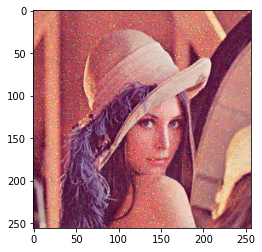

In [93]:
plt.imshow(np.transpose(output, (1, 2, 0)))  # 학습시 입력으로 이용되는 masked 이미지 (마스킹된 픽셀들에 대해서만 손실 계산)

## 2. model.py (UNet)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### 2.1 For encoder

In [2]:
# Down-sampling Conv (일반적인 conv 연산 - 해상도는 줄이고, 채널은 깊게)
class Conv2d(nn.Module):
    def __init__(self, nch_in, nch_out, kernel_size=4, stride=1, padding=1, bias=True):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(nch_in, nch_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)

    def forward(self, x):
        return self.conv(x)

In [3]:
class Norm2d(nn.Module):
    def __init__(self, nch, norm_mode):
        super(Norm2d, self).__init__()
        if norm_mode == 'bnorm':
            self.norm = nn.BatchNorm2d(nch)
            
        elif norm_mode == 'inorm':
            self.norm = nn.InstanceNorm2d(nch)

    def forward(self, x):
        return self.norm(x)

In [4]:
class ReLU(nn.Module):
    def __init__(self, relu):
        super(ReLU, self).__init__()
        if relu > 0:
            self.relu = nn.LeakyReLU(relu, True)
            
        elif relu == 0:
            self.relu = nn.ReLU(True)

    def forward(self, x):
        return self.relu(x)

In [6]:
class Pooling2d(nn.Module):
    def __init__(self, nch=[], pool=2, type='avg'):
        super().__init__()

        if type == 'avg':
            self.pooling = nn.AvgPool2d(pool)
        elif type == 'max':
            self.pooling = nn.MaxPool2d(pool)
        elif type == 'conv':
            self.pooling = nn.Conv2d(nch, nch, kernel_size=pool, stride=pool)

    def forward(self, x):
        return self.pooling(x)

In [5]:
# Conv layer for Encoder
class CNR2d(nn.Module):
    def __init__(self, nch_in, nch_out, kernel_size=4, stride=1, padding=1, norm='bnorm', relu=0.0, drop=[], bias=[]):
        super().__init__()

        if bias == []:
            if norm == 'bnorm':
                bias = False
            else:
                bias = True

        layers = []
        layers += [Conv2d(nch_in, nch_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]

        if norm != []:
            layers += [Norm2d(nch_out, norm)]

        if relu != []:
            layers += [ReLU(relu)]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        self.cbr = nn.Sequential(*layers)  # 기본적인 conv layer위에 norm/relu/drop layer를 취사 선택하여 쌓음

    def forward(self, x):
        return self.cbr(x)

### 2.2 For decoder

In [8]:
# Up-sampling Conv
class Deconv2d(nn.Module):
    def __init__(self, nch_in, nch_out, kernel_size=4, stride=1, padding=1, output_padding=0, bias=True):
        super(Deconv2d, self).__init__()
        self.deconv = nn.ConvTranspose2d(nch_in, nch_out, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding, bias=bias)  # output_padding : default=0

        # layers = [nn.Upsample(scale_factor=2, mode='bilinear'),
        #           nn.ReflectionPad2d(1),
        #           nn.Conv2d(nch_in , nch_out, kernel_size=3, stride=1, padding=0)]
        #
        # self.deconv = nn.Sequential(*layers)

    def forward(self, x):
        return self.deconv(x)

In [9]:
# 해상도를 증가시킴 (일반적인 pooling의 반대)
class UnPooling2d(nn.Module):
    def __init__(self, nch=[], pool=2, type='nearest'):
        super().__init__()

        if type == 'nearest':
            self.unpooling = nn.Upsample(scale_factor=pool, mode='nearest')  # scale_factor배 만큼 해상도 증가
        elif type == 'bilinear':
            self.unpooling = nn.Upsample(scale_factor=pool, mode='bilinear', align_corners=True)
        elif type == 'conv':
            self.unpooling = nn.ConvTranspose2d(nch, nch, kernel_size=pool, stride=pool)

    def forward(self, x):
        return self.unpooling(x)

In [7]:
# Decoder conv 
class DECNR2d(nn.Module):
    def __init__(self, nch_in, nch_out, kernel_size=4, stride=1, padding=1, output_padding=0, norm='bnorm', relu=0.0, drop=[], bias=[]):
        super().__init__()

        if bias == []:
            if norm == 'bnorm':
                bias = False
            else:
                bias = True

        layers = []
        layers += [Deconv2d(nch_in, nch_out, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding, bias=bias)]

        if norm != []:
            layers += [Norm2d(nch_out, norm)]

        if relu != []:
            layers += [ReLU(relu)]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        self.decbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.decbr(x)

### 1.3 UNet architecture

In [11]:
#from layer import *  (https://github.com/hanyoseob/pytorch-noise2void/blob/master/layer.py)

import torch
import torch.nn as nn
from torch.nn import init
from torch.optim import lr_scheduler

In [23]:
class UNet(nn.Module):
    def __init__(self, nch_in, nch_out, nch_ker=64, norm='bnorm'):
        super(UNet, self).__init__()

        self.nch_in = nch_in
        self.nch_out = nch_out
        self.nch_ker = nch_ker
        self.norm = norm

        if norm == 'bnorm':
            self.bias = False
        else:
            self.bias = True

        """
        Encoder part (해상도는 줄고, 채널은 증가하는 것을 확인)
        """
        self.enc1_1 = CNR2d(1 * self.nch_in,  1 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])  # padding=1이 default
        self.enc1_2 = CNR2d(1 * self.nch_ker, 1 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])

        self.pool1 = Pooling2d(pool=2, type='avg')

        self.enc2_1 = CNR2d(1 * self.nch_ker, 2 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])
        self.enc2_2 = CNR2d(2 * self.nch_ker, 2 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])

        self.pool2 = Pooling2d(pool=2, type='avg')

        self.enc3_1 = CNR2d(2 * self.nch_ker, 4 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])
        self.enc3_2 = CNR2d(4 * self.nch_ker, 4 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])

        self.pool3 = Pooling2d(pool=2, type='avg')

        self.enc4_1 = CNR2d(4 * self.nch_ker, 8 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])
        self.enc4_2 = CNR2d(8 * self.nch_ker, 8 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])

        self.pool4 = Pooling2d(pool=2, type='avg')

        self.enc5_1 = CNR2d(8 * self.nch_ker, 2 * 8 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])

        """
        Decoder part (unpoolig을 통해 해상도가 증가하고, Conv2DTranspose를 통해 채널이 감소하는 것을 확인)
        """
        self.dec5_1 = DECNR2d(2 * 8 * self.nch_ker, 8 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])  # padding=1이 default

        self.unpool4 = UnPooling2d(pool=2, type='nearest')

        self.dec4_2 = DECNR2d(2 * 8 * self.nch_ker, 8 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])
        self.dec4_1 = DECNR2d(8 * self.nch_ker,     4 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])

        self.unpool3 = UnPooling2d(pool=2, type='nearest')

        self.dec3_2 = DECNR2d(2 * 4 * self.nch_ker, 4 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])
        self.dec3_1 = DECNR2d(4 * self.nch_ker,     2 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])

        self.unpool2 = UnPooling2d(pool=2, type='nearest')

        self.dec2_2 = DECNR2d(2 * 2 * self.nch_ker, 2 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])
        self.dec2_1 = DECNR2d(2 * self.nch_ker,     1 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])

        self.unpool1 = UnPooling2d(pool=2, type='nearest')

        self.dec1_2 = DECNR2d(2 * 1 * self.nch_ker, 1 * self.nch_ker, kernel_size=3, stride=1, norm=self.norm, relu=0.0, drop=[])
        self.dec1_1 = DECNR2d(1 * self.nch_ker,     1 * self.nch_out, kernel_size=3, stride=1, norm=[],        relu=[],  drop=[], bias=False)


    def forward(self, x):

        """
        Encoder part (x : [1, 3, 256, 256])
        """

        enc1 = self.enc1_2(self.enc1_1(x))  # [1, 64, 256, 256]
        pool1 = self.pool1(enc1)  # [1, 64, 128, 128]

        enc2 = self.enc2_2(self.enc2_1(pool1))  # [1, 128, 128, 128]
        pool2 = self.pool2(enc2)  # [1, 128, 64, 64]

        enc3 = self.enc3_2(self.enc3_1(pool2))  # [1, 256, 64, 64]
        pool3 = self.pool3(enc3)  # [1, 256, 32, 32]

        enc4 = self.enc4_2(self.enc4_1(pool3))  # [1, 512, 32, 32]
        pool4 = self.pool4(enc4)  # [1, 512, 16, 16]

        enc5 = self.enc5_1(pool4)  # [1, 1024, 16, 16]

        """
        Decoder part
        """
        dec5 = self.dec5_1(enc5)  # [1, 512, 16, 16]

        unpool4 = self.unpool4(dec5)  # [1, 512, 32, 32] - enc4와 같은 크기
        cat4 = torch.cat([enc4, unpool4], dim=1)  # [1, 1024, 32, 32]
        dec4 = self.dec4_1(self.dec4_2(cat4))  # [1, 256, 32, 32]

        unpool3 = self.unpool3(dec4)  # [1, 256, 64, 64] - enc3과 같은 크기
        cat3 = torch.cat([enc3, unpool3], dim=1)  # [1, 512, 64, 64]
        dec3 = self.dec3_1(self.dec3_2(cat3))  # [1, 128, 64, 64]

        unpool2 = self.unpool2(dec3)  # [1, 128, 128, 128]
        cat2 = torch.cat([enc2, unpool2], dim=1)  # [1, 256, 128, 128]
        dec2 = self.dec2_1(self.dec2_2(cat2))  # [1, 64, 128, 128]

        unpool1 = self.unpool1(dec2)  # [1, 64, 256, 256]
        cat1 = torch.cat([enc1, unpool1], dim=1)  # [1, 128, 256, 256]
        dec1 = self.dec1_1(self.dec1_2(cat1))  # [1, 3, 256, 256]

        x = dec1

        return x

In [24]:
# main.py, dataset.py의 default setting 이용
nch_in = 3
nch_out = 3
x = torch.randn([1, 3, 256, 256])

model = UNet(nch_in, nch_out)

output = model(x)
print(output.shape)

torch.Size([1, 3, 256, 256])


## 3. train.py

loss 계산에 주목

`A specialized loss function that is zero for all but the selected pixels`

학습을 진행하기 위해서는 하나의 pixel 예측값에 대해 모든 patch에 걸쳐서 gradient를 계산해야 하는 비효율성을 해결 (일종의 approximation)

In [ ]:
## setup network
netG = UNet(nch_in, nch_out, nch_ker, norm)
#netG = ResNet(nch_in, nch_out, nch_ker, norm)

init_net(netG, init_type='normal', init_gain=0.02, gpu_ids=gpu_ids)

## setup loss & optimization
fn_REG = nn.L1Loss().to(device)  # Regression loss: L1

paramsG = netG.parameters()

optimG = torch.optim.Adam(paramsG, lr=lr_G, betas=(self.beta1, 0.999))

for epoch in range(st_epoch + 1, num_epoch + 1):
    ## training phase
    netG.train()

    loss_G_train = []

    for batch, data in enumerate(loader_train, 1):
        def should(freq):
            return freq > 0 and (batch % freq == 0 or batch == num_batch_train)

            label = data['label'].to(device)  # noise 이미지
            input = data['input'].to(device)  # noise 이미지에 masking이 적용된 이미지
            mask = data['mask'].to(device)  # blind spot masking 행렬 (blind spot은 0, 아니면 1)

            # forward netG
            output = netG(input)

            # backward netG
            optimG.zero_grad()
            
            # blind spot에 해당하는 픽셀은 그 값을 유지하고, 나머지 픽셀들은 0이됨
            loss_G = fn_REG(output * (1 - mask), label * (1 - mask))  

            loss_G.backward()
            optimG.step()

            # get losses
            loss_G_train += [loss_G.item()]

            print('TRAIN: EPOCH %d: BATCH %04d/%04d: LOSS: %.4f'
                      % (epoch, batch, num_batch_train, np.mean(loss_G_train)))